In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

from tqdm import tqdm

In [2]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [3]:
def ResNet50(img_channel=1, num_classes=6):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

def test():
    BATCH_SIZE = 1024
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet50(img_channel=1, num_classes=6).to(device)

    input_tensor = torch.randn(BATCH_SIZE, 1, 64, 64).to(device)
    y = net(input_tensor)

    assert y.size() == torch.Size([BATCH_SIZE, 6])
    print("Output shape:", y.size())

In [4]:
# if __name__ == "__main__":
#     test()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(ResNet50(img_channel=1, num_classes=6).to(device), input_size=(1, 64, 64), batch_size=1024)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1024, 64, 32, 32]           3,136
       BatchNorm2d-2         [1024, 64, 32, 32]             128
              ReLU-3         [1024, 64, 32, 32]               0
         MaxPool2d-4         [1024, 64, 16, 16]               0
            Conv2d-5         [1024, 64, 16, 16]           4,096
       BatchNorm2d-6         [1024, 64, 16, 16]             128
              ReLU-7         [1024, 64, 16, 16]               0
            Conv2d-8         [1024, 64, 16, 16]          36,864
       BatchNorm2d-9         [1024, 64, 16, 16]             128
             ReLU-10         [1024, 64, 16, 16]               0
           Conv2d-11        [1024, 256, 16, 16]          16,384
      BatchNorm2d-12        [1024, 256, 16, 16]             512
           Conv2d-13        [1024, 256, 16, 16]          16,384
      BatchNorm2d-14        [1024, 256,

In [6]:
def save_checkpoint(model, optimizer, epoch, checkpoint_dir="Resnet50_checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}_{timestamp}.pth.tar")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_checkpoint(model, optimizer=None, checkpoint_path="latest_checkpoint.pth"):
    if not os.path.exists(checkpoint_path):
        print("Checkpoint not found!")
        return None

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {checkpoint_path}, Epoch: {epoch}")
    return epoch

def predict_image(model, image_path, class_labels):
    model.eval()
    image = Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        spk_rec, _ = model(image)
        predicted_class = torch.argmax(spk_rec, dim=1).item()

    print(f"Predicted Class: {class_labels[predicted_class]}")

    # Plot image
    plt.imshow(Image.open(image_path), cmap="gray")
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis("off")
    plt.show()

In [ ]:
data_path='E:/Code/SCNN-and-Resnet50-on-Medical-MNIST-classification/data/raw'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 512
num_epochs = 5
LOAD_MODEL = False
dtype = torch.float
model = ResNet50(img_channel=1, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)

In [8]:
transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_dataset = datasets.ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(mnist_dataset))  
test_size = len(mnist_dataset) - train_size  

mnist_train, mnist_test = random_split(mnist_dataset, [train_size, test_size])

print(len(mnist_train))
print(len(mnist_test))

print(mnist_dataset.class_to_idx)
print(mnist_dataset.classes)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

47163
11791
{'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


Epoch [1/5]:   0%|                                                           | 0/92 [00:00<?, ?it/s]

Epoch [1/5]: 100%|██████████████████████████| 92/92 [07:36<00:00,  4.96s/it, acc=47.6, loss=0.00267]


Checkpoint saved: Resnet50_checkpoints\checkpoint_epoch_0_20250408_053431.pth.tar


Epoch [2/5]: 100%|██████████████████████████| 92/92 [01:37<00:00,  1.06s/it, acc=74.4, loss=0.00198]


Checkpoint saved: Resnet50_checkpoints\checkpoint_epoch_1_20250408_053610.pth.tar


Epoch [3/5]: 100%|██████████████████████████| 92/92 [01:33<00:00,  1.02s/it, acc=81.8, loss=0.00165]


Checkpoint saved: Resnet50_checkpoints\checkpoint_epoch_2_20250408_053744.pth.tar


Epoch [4/5]: 100%|██████████████████████████| 92/92 [01:33<00:00,  1.01s/it, acc=84.6, loss=0.00144]


Checkpoint saved: Resnet50_checkpoints\checkpoint_epoch_3_20250408_053917.pth.tar


Epoch [5/5]: 100%|██████████████████████████| 92/92 [01:33<00:00,  1.02s/it, acc=86.4, loss=0.00129]


Checkpoint saved: Resnet50_checkpoints\checkpoint_epoch_4_20250408_054051.pth.tar
Epoch 5, Loss: 60.6233, Accuracy: 86.41%


Evaluating: 100%|█████████████████████████████████████████| 23/23 [01:53<00:00,  4.92s/it, acc=86.5]


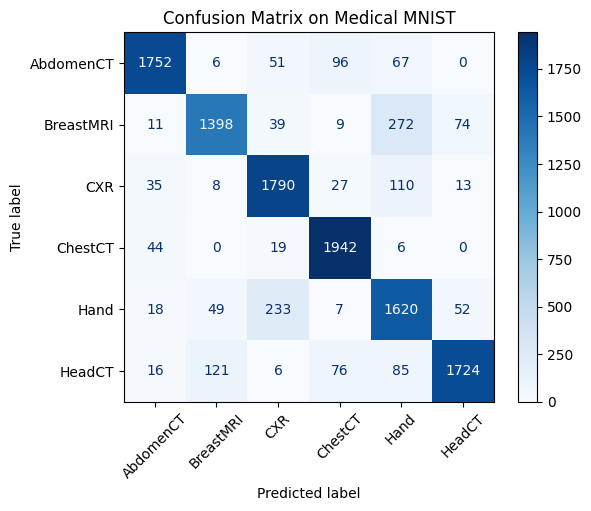

In [ ]:
if LOAD_MODEL:
    load_checkpoint(model, optimizer, "Resnet50_checkpoints/checkpoint_epoch_4_20250408_054051.pth.tar")
    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss / total, acc=100.0 * correct / total)
        
    save_checkpoint(model, optimizer, epoch=epoch)

acc = 100 * correct / total
print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(acc=100.0 * correct / total)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(mnist_dataset.class_to_idx.keys()))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Medical MNIST")
plt.show()